In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
import pydicom

In [2]:
df0 = pd.read_excel('Lab3Data/OSLDLAb2022.xlsx', sheet_name='Calibration',
                    skiprows=2, nrows=11, usecols='A:C')
df200 = pd.read_excel('Lab3Data/OSLDLAb2022.xlsx', sheet_name='Calibration',
                    skiprows=16, nrows=11, usecols='A:C')
df400 = pd.read_excel('Lab3Data/OSLDLAb2022.xlsx', sheet_name='Calibration',
                    skiprows=31, nrows=12, usecols='A:C')
df50 = pd.read_excel('Lab3Data/OSLDLAb2022.xlsx', sheet_name='Calibration',
                    skiprows=2, nrows=11, usecols='E:G')
df300 = pd.read_excel('Lab3Data/OSLDLAb2022.xlsx', sheet_name='Calibration',
                    skiprows=16, nrows=13, usecols='E:G')
df100 = pd.read_excel('Lab3Data/OSLDLAb2022.xlsx', sheet_name='Calibration',
                    skiprows=2, nrows=34, usecols='I:L')

Get doses

In [3]:
D = np.array([0, 50, 100, 200, 300, 400])
MU = np.round(D/0.772)
D = MU*0.772

# Exercise 1

In [4]:
df100['norm_counts'] = (df100[df100.columns[3]] - df100[df100.columns[2]])/df100[df100.columns[1]]

In [5]:
orange_bois = ['DB08800561V', 'DB08803503U', 'DB08700184W', 'DB08503029T']
dfgood = df100[~df100['Serial Number.2'].isin(orange_bois)]
dfbad = df100[df100['Serial Number.2'].isin(orange_bois)]

In [6]:
dfgood.groupby('Serial Number.2').mean()

,Sensitivity.2,Pre-read (PMT Counts),PMT Counts.2,norm_counts
Serial Number.2,,,,
DN083541920,0.83,781.333333,72371.000000,86252.612176
DN08360545T,0.83,726.333333,69880.333333,83318.073964
DN09044495R,0.90,4066.000000,77078.000000,81124.446594
DN09269290U,0.92,796.333333,78835.666667,84825.360780
DN098024036,0.98,1556.333333,77233.666667,77221.767205
DN101020040,1.01,1560.000000,75433.600000,73142.178908


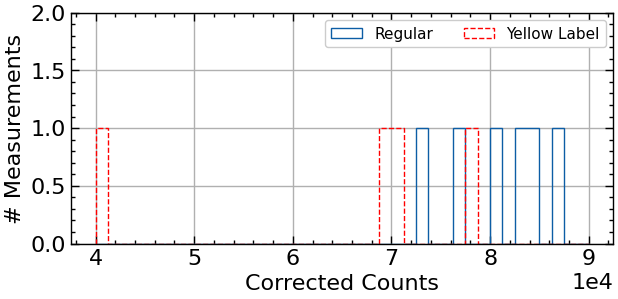

In [7]:
plt.figure(figsize=(7,3))
plt.hist(dfgood.groupby('Serial Number.2').mean().norm_counts.values, bins=40, range=(40000,90000), histtype='step', label='Regular')
plt.hist(dfbad.groupby('Serial Number.2').mean().norm_counts.values, bins=40, range=(40000,90000), histtype='step', label='Yellow Label', color='red', ls='--')
plt.xlabel('Corrected Counts')
plt.ylabel('# Measurements')
plt.ylim(top=2)
plt.grid()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc='upper right', facecolor='white', framealpha=1, frameon=True, fontsize=11, ncol=2)
plt.savefig('Lab3Plots/fig1.png', dpi=300)
plt.show()

Compute relative uncertainty

In [8]:
good_cc = dfgood.groupby('Serial Number.2').mean().norm_counts.values
np.mean(good_cc)

80980.73993785697

In [9]:
rel_unc = np.std(good_cc)/np.mean(good_cc)
rel_unc

0.05605383713633518

In [10]:
np.std(good_cc)

4539.281207656549

Fix this dataframe for next parts of the lab

In [11]:
df100 = dfgood
df100['Sensitivity'] = df100['Sensitivity.2']
df100['PMT Counts'] = df100['PMT Counts.2']
df100['Serial Number'] = df100['Serial Number.2']

# Exercise 2

In [12]:
df50['PMT Counts'] = df50['PMT Counts.1']
df50['Sensitivity'] = df50['Sensitivity.1']
df50['Serial Number'] = df50['Serial Number.1']
df300['PMT Counts'] = df300['PMT Counts.1']
df300['Sensitivity'] = df300['Sensitivity.1']
df300['Serial Number'] = df300['Serial Number.1']
# Get rid of outilier in 200cGy data
df200['Adjusted Counts'] = df200['PMT Counts']/df200['Sensitivity']
df200 = df200[df200['Adjusted Counts']>145000]
# Make array of dataframes
dfs = [df0, df50, df100, df200, df300, df400]

In [13]:
def get_mean_norm_counts(df):
    return np.mean(df['PMT Counts'].values/df['Sensitivity'].values)
def get_norm_counts(dfs):
    values = []
    for df in dfs:
        a = df.groupby('Serial Number').mean()
        values.append(a['PMT Counts'].values/a['Sensitivity'].values)
    return values
def get_std_norm_counts(df):
    return np.std(df['PMT Counts'].values/df['Sensitivity'].values)

In [14]:
mean_norm_counts = np.array([get_mean_norm_counts(df) for df in dfs])
norm_counts = get_norm_counts(dfs)
std_norm_counts = np.array([get_std_norm_counts(df) for df in dfs])

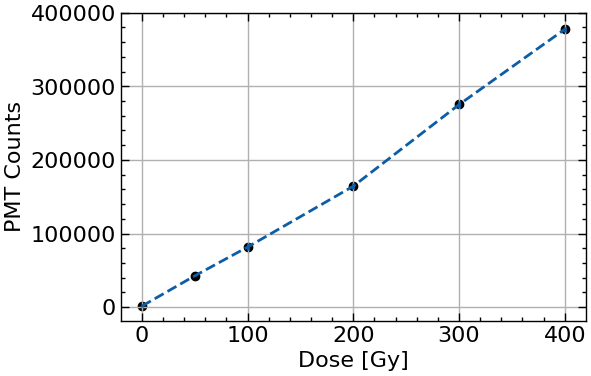

In [15]:
plt.figure(figsize=(6,4))
plt.scatter(D, mean_norm_counts, color='k')
plt.errorbar(x=D, y=mean_norm_counts, yerr=std_norm_counts, ls='--')
plt.xlabel('Dose [Gy]')
plt.ylabel('PMT Counts')
plt.grid()
plt.show()

How to obtain error:

$$95\% \text{  Interval} = \hat{y} \pm t_{crit} s_e$$

where 

$$s_e = 

In [16]:
def get_ci_manual(t, MSE, n, x, x2, y2, ax=None):  
    ci = t*np.sqrt(MSE) * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    return ci

def line(x, m, b):
    return m*x+b

def get_line_and_CI(xdata,ydata,yerrdata):
    # Fit to Curve
    popt, pcov = curve_fit(line, xdata, ydata, sigma=yerrdata)
    xfit = np.linspace(np.min(xdata), np.max(xdata), 100)
    yfit = line(xfit, popt[0], popt[1])
    # Statistics
    NN = xdata.size
    NP = 2               
    dof = NN - NP                   
    t = stats.t.ppf(1-0.33/2, dof)  
    # Estimates of Error in Data/Model
    m, b = popt
    y_model = m*xdata + b
    resid = ydata - y_model                                                           
    MSE = np.mean(resid**2)
    # Confidence Interval
    ci = get_ci_manual(t, MSE, NN, xdata, xfit, yfit)
    return xdata, ydata, yerrdata, xfit, yfit, ci, popt, pcov

Get fit data

In [17]:
xdata, ydata, yerrdata, xfit, yfit, ci, popt, pcov = get_line_and_CI(D,
                                                                     mean_norm_counts,
                                                                     std_norm_counts)
m, m_err = popt[0], np.sqrt(pcov[0,0])
b, b_err = popt[1], np.sqrt(pcov[1,1])


In [18]:
def compute_chi2(xdata, ydata, yerrdata, model, params):
    return 1/(len(xdata)-2) * sum(((ydata - model(xdata, *params))/yerrdata)**2)
compute_chi2(xdata, ydata, yerrdata, line, (m,b))

12.649236130674403

Plot data with prediction interval:

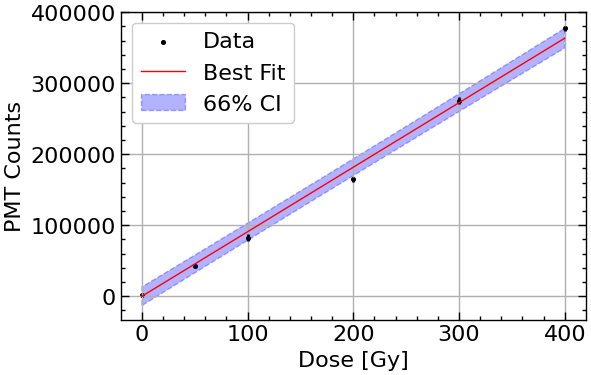

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(D, mean_norm_counts, color='k', s=7, label='Data')
plt.errorbar(x=D, y=mean_norm_counts, yerr=std_norm_counts, ls='', color='k')
plt.plot(xfit, yfit, color='r', label='Best Fit', lw=1)
plt.xlabel('Dose [Gy]')
plt.ylabel('PMT Counts')
plt.grid()
plt.fill_between(xfit, yfit + ci, yfit - ci, color="blue", linestyle="--", alpha=0.3, label='66% CI')
plt.legend(loc='upper left', facecolor='white', framealpha=1, frameon=True)
plt.show()

Don't include 0 point

In [20]:
avg_rel_unc = np.mean(np.abs((ydata[1:] - (m*xdata[1:]+b))/ydata[1:]))
avg_rel_unc

0.06524806290362951

Or RMSE

In [21]:
RMSE = np.sqrt(np.mean((ydata-(m*xdata+b))**2))
RMSE

9942.436132903491

Can also fit to function

$$C = a - \sqrt{a^2 + b D}$$

In [22]:
def root_func(x, a, b):
    return a-np.sqrt(a**2 + b*x)

def root_func_prediction(x, a, b, xnorm, ynorm):
    return ynorm * root_func(x/xnorm, a, b)

In [23]:
xnorm = 400
ynorm = 400000
(a,b), _ = curve_fit(root_func, D/xnorm, mean_norm_counts/ynorm)

<ipython-input-22-27858016516b>:2: RuntimeWarning: invalid value encountered in sqrt
  return a-np.sqrt(a**2 + b*x)


In [24]:
ynorm*a
ynorm**2 / xnorm * b

-1797978348.2555885

In [25]:
D_fit = np.arange(400)
C_fit = root_func_prediction(D_fit, a, b, xnorm, ynorm)
res = mean_norm_counts - root_func_prediction(D, a, b, xnorm, ynorm)

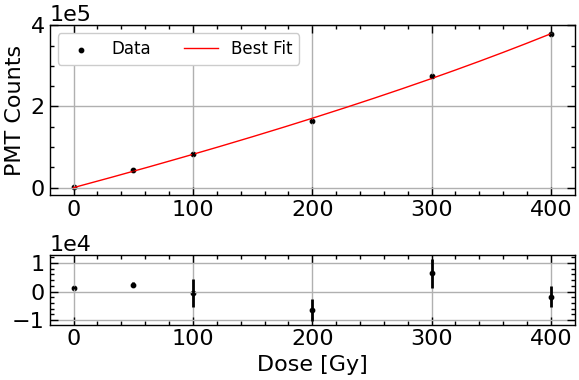

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [3, 1.22]})
plt.subplot(211)
plt.scatter(D, mean_norm_counts, color='k', s=10, label='Data')
plt.plot(D_fit, C_fit, color='r', label='Best Fit', lw=1)
plt.errorbar(x=D, y=mean_norm_counts, yerr=std_norm_counts, ls='', color='k')
plt.ylabel('PMT Counts')
plt.grid()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='upper left', facecolor='white', framealpha=1, frameon=True, ncol=2, fontsize=12)
plt.subplot(212)
plt.scatter(D, res, color='k', s=10)
plt.errorbar(x=D, y=res, yerr=std_norm_counts, ls='', color='k')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.xlabel('Dose [Gy]')
fig.tight_layout()
plt.savefig('Lab3Plots/fig2.png', dpi=200)
plt.show()

In [27]:
compute_chi2(xdata, ydata, yerrdata, root_func_prediction, (a,b,xnorm,ynorm))

3.8726487519315667

Then can get dose from counts using

$$D = AC + BC^2$$

where

* $B= 1/b$
* $A = -2Ba$

In [28]:
B = 1/b
A = -2*B*a

Make quadratic prediction

In [29]:
def quadra_prediction(x, A, B, xnorm, ynorm):
    return ynorm * (A*(x/xnorm) + B*(x/xnorm)**2)

In [30]:
counts = np.arange(400000)
xnorm = 400000
ynorm = 400
D_pred = quadra_prediction(counts, A, B, xnorm, ynorm)

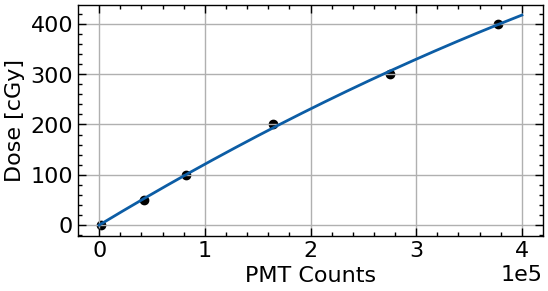

In [31]:
plt.figure(figsize=(6,3))
plt.plot(counts, D_pred)
plt.scatter(mean_norm_counts, D, color='k')
plt.grid()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('PMT Counts')
plt.ylabel('Dose [cGy]')
plt.show()

The error **for repeated readings on a single OSLD** (all of which are approximately equal) can be **roughly approximated** by looking at all residuals

In [32]:
res = [Di - quadra_prediction(norm_count, A, B, xnorm, ynorm) \
       for (Di,norm_count) in zip(D, norm_counts)]
np.std(np.concatenate(res))

5.291465240746536

In [33]:
relres = [np.abs((Di - quadra_prediction(norm_count, A, B, xnorm, ynorm)))/Di * 100 \
       for (Di,norm_count) in zip(D[1:], norm_counts[1:])]
np.mean(np.concatenate(relres))

3.650090078706551

In [34]:
D

array([  0.   ,  50.18 , 100.36 , 199.948, 300.308, 399.896])

**Note**: Some data points are biased, hence why the standard dev of each given dose is less than the overall std dev

In [35]:
[np.std(r) for r in res]

[0.8117080966510046,
 1.0275502920458195,
 5.24428624812072,
 4.300047285243963,
 4.838107278787148,
 2.8740081289956096]

So the approximate error on a single reading when computed using the calibration curve is the above quantity in cGy

# Exercise 3

In [52]:
df = pd.read_excel('Lab3Data/OSLDLAb2022.xlsx', sheet_name='Pattern',
                    skiprows=4, nrows=19, usecols='L:N')
counts_norm = df['PMT Counts'].values/df['Sensitivity'].values
df['Dose'] = D_pred = quadra_prediction(counts_norm, A, B, xnorm, ynorm)
dfmean = df.groupby('Serial Number').mean()
dfstd = df.groupby('Serial Number').std()

Get predicted doses

In [53]:
D_pred = dfmean['Dose'].values

Get corresponding locations (from pdf picture on canvas)

In [54]:
xs = np.array([0,4,-1, 1.5, -5])
ys = np.array([0,3.5,2.5, -1.5, -7.5])

Plot

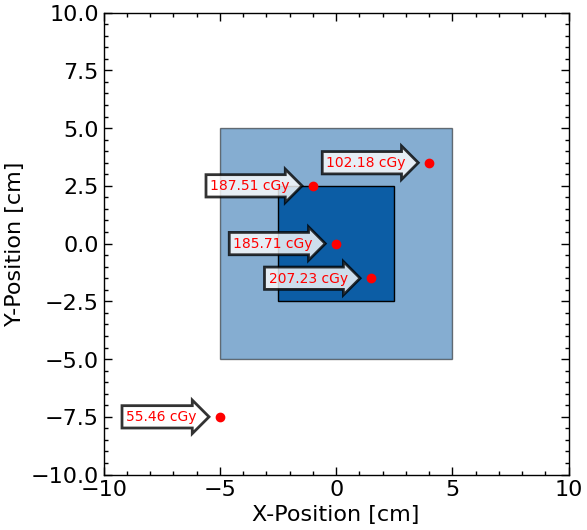

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
rectangle = plt.Rectangle((-5,-5),10,10, ec="k", alpha=0.5)
plt.gca().add_patch(rectangle)
rectangle = plt.Rectangle((-2.5,-2.5),5,5, ec="k")
plt.gca().add_patch(rectangle)
plt.scatter(xs, ys, color='r')
plt.xlim(-10, 10)
plt.ylim(-10,10)
plt.xlabel('X-Position [cm]')
plt.ylabel('Y-Position [cm]')
for i, D in enumerate(D_pred):
    ax.annotate(f'{D:.2f} cGy', (xs[i]-1, ys[i]), color='r', ha='right', va='center',
               bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=2, alpha=0.8))
plt.show()

Compare to the treatment planning dose

In [40]:
TPdose1mm = pydicom.read_file('Lab2Data/TPdose_calc_1mm_res.dcm')
f1mm = float(TPdose1mm.DoseGridScaling)
pred_dose = TPdose1mm.pixel_array * f1mm

In [41]:
np.max(pred_dose)

2.0098326228

The center is a bit off

In [42]:
center = (150-2, 150+1)

In [43]:
def get_pred_dose(x, y):
    x = int(x*10)
    y = int(y*10)
    return pred_dose[center[1]+y, center[0]+x] * 100

In [44]:
D_pred_treatment = np.vectorize(get_pred_dose)(xs,ys)

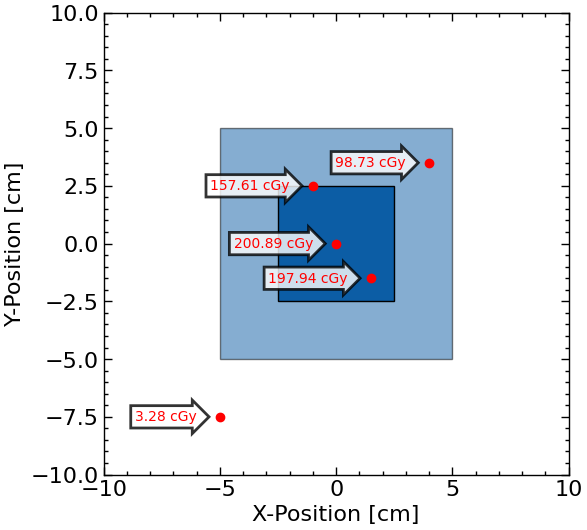

In [45]:
fig, ax = plt.subplots(figsize=(6,6))
rectangle = plt.Rectangle((-5,-5),10,10, ec="k", alpha=0.5)
plt.gca().add_patch(rectangle)
rectangle = plt.Rectangle((-2.5,-2.5),5,5, ec="k")
plt.gca().add_patch(rectangle)
plt.scatter(xs, ys, color='r')
plt.xlim(-10, 10)
plt.ylim(-10,10)
plt.xlabel('X-Position [cm]')
plt.ylabel('Y-Position [cm]')
for i, D in enumerate(D_pred_treatment):
    ax.annotate(f'{D:.2f} cGy', (xs[i]-1, ys[i]), color='r', ha='right', va='center',
               bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=2, alpha=0.8))
plt.show()

Plot with both things

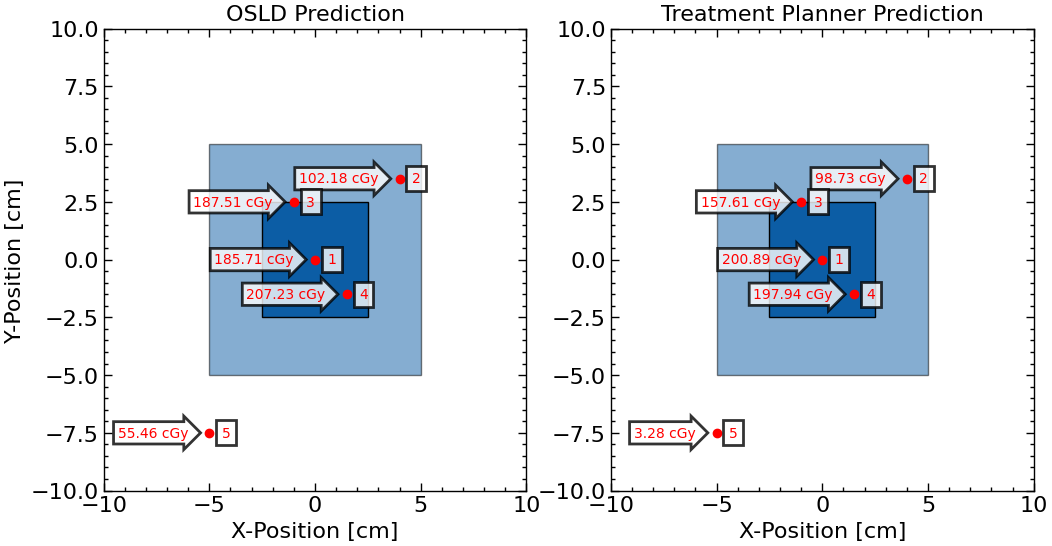

In [46]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
plt.subplot(121)
rectangle = plt.Rectangle((-5,-5),10,10, ec="k", alpha=0.5)
plt.gca().add_patch(rectangle)
rectangle = plt.Rectangle((-2.5,-2.5),5,5, ec="k")
plt.gca().add_patch(rectangle)
plt.scatter(xs, ys, color='r')
plt.xlim(-10, 10)
plt.ylim(-10,10)
plt.xlabel('X-Position [cm]')
plt.ylabel('Y-Position [cm]')
for i, D in enumerate(D_pred):
    axes[0].annotate(f'{D:.2f} cGy', (xs[i]-1, ys[i]), color='r', ha='right', va='center',
               bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=2, alpha=0.8))
    axes[0].annotate(f'{i+1}', (xs[i]+1, ys[i]), color='r', ha='right', va='center',
               bbox=dict(fc="white", ec="k", lw=2, alpha=0.8))
plt.title('OSLD Prediction')
plt.subplot(122)
rectangle = plt.Rectangle((-5,-5),10,10, ec="k", alpha=0.5)
plt.gca().add_patch(rectangle)
rectangle = plt.Rectangle((-2.5,-2.5),5,5, ec="k")
plt.gca().add_patch(rectangle)
plt.scatter(xs, ys, color='r')
plt.xlim(-10, 10)
plt.ylim(-10,10)
plt.xlabel('X-Position [cm]')
for i, D in enumerate(D_pred_treatment):
    axes[1].annotate(f'{D:.2f} cGy', (xs[i]-1, ys[i]), color='r', ha='right', va='center',
               bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=2, alpha=0.8))
    axes[1].annotate(f'{i+1}', (xs[i]+1, ys[i]), color='r', ha='right', va='center',
               bbox=dict(fc="white", ec="k", lw=2, alpha=0.8))
plt.title('Treatment Planner Prediction')
plt.savefig('Lab3Plots/fig3.png', dpi=200)
plt.show()

In [47]:
(D_pred - D_pred_treatment)/D_pred_treatment * 100

array([  -7.55550653,    3.49746243,   18.96875692,    4.69219484,
       1588.50376591])